# Importation de Libreries

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import missingno as msno
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

# Chargement des données

In [6]:
train = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP3/tweet-sentiment-extraction/Data/train.csv")

test = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP3/tweet-sentiment-extraction/Data/test.csv")

sample_submission = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP3/tweet-sentiment-extraction/Data/sample_submission.csv")

In [7]:
train.shape, test.shape

((27481, 4), (3534, 3))

# Trouver les valeurs manquantent

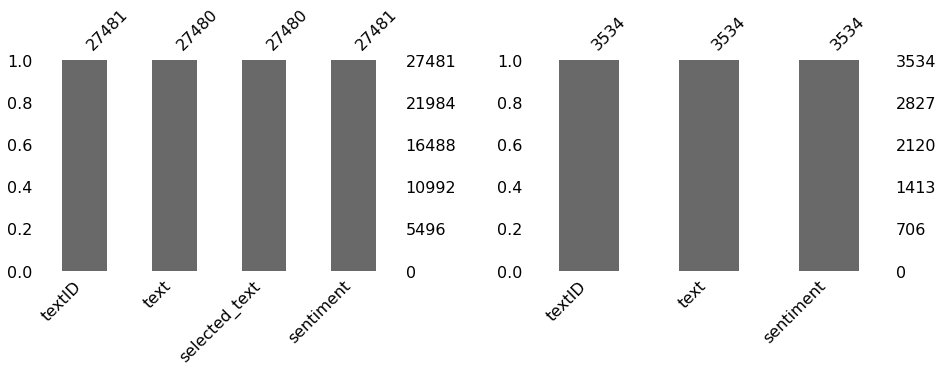

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
plt.tight_layout(pad = 10)
msno.bar(train, ax = axes[0])
msno.bar(test, ax = axes[1])

##### Il manque une valeur dans la colonne text et selected_text dans les données relatives aux trains



In [10]:
print(train[train["text"].isnull() == True])
# # Nous pouvons laisser tomber cette rangée
train.dropna(inplace = True)

textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral


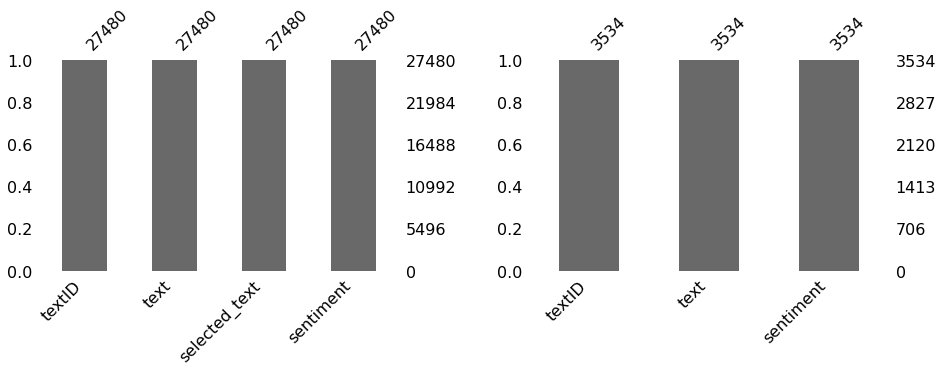

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
plt.tight_layout(pad = 10)
msno.bar(train, ax = axes[0])
msno.bar(test, ax = axes[1])

##### Pas de valeur nulle dans le train et les données d'essai



# Répartition de la classe manquante

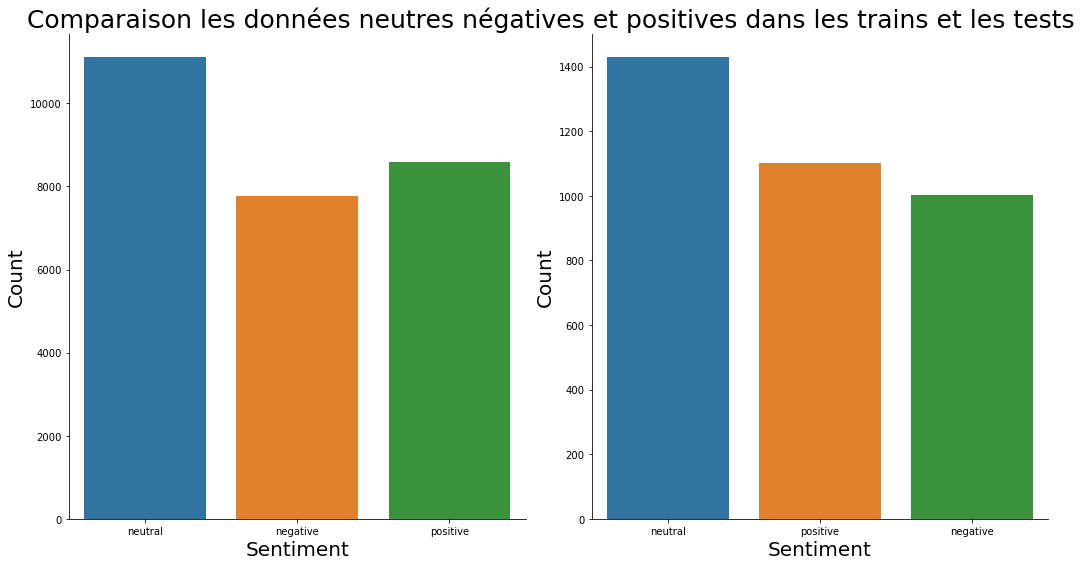

In [12]:
# Répartition de la classe de sentiment
fig, axes = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle("Comparaison les données neutres négatives et positives dans les trains et les tests", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "sentiment", data = train, ax = axes[0])
sns.countplot(x = "sentiment", data = test, ax = axes[1])
axes[0].set_xlabel("Sentiment", fontsize = 20)
axes[0].set_ylabel("Count", fontsize = 20)
axes[1].set_xlabel("Sentiment", fontsize = 20)
axes[1].set_ylabel("Count", fontsize = 20)
sns.despine()

## Pourcentage de mots neutres, négatifs, positifs dans le train et données de test

In [13]:
def pert_count(data, category):
    return (len(data[data["sentiment"] == category])/len(data)) * 100

print(f"Pourcentage de mots neutres dans le train --> {pert_count(train, 'neutral')}%")
print(f"Pourcentage de mots negatifs dans le train --> {pert_count(train, 'negative')}%")
print(f"Pourcentage de mots positifs dans le train --> {pert_count(train, 'positive')}%")
print(f"Pourcentage de mots neutres dans le test --> {pert_count(test, 'neutral')}%")
print(f"Pourcentage de mots negatifs dans le test --> {pert_count(test, 'negative')}%")
print(f"Pourcentage de mots positifs dans le test --> {pert_count(test, 'positive')}%")

Pourcentage de mots neutres dans le train --> 40.45487627365357%
Pourcentage de mots negatifs dans le train --> 28.315138282387192%
Pourcentage de mots positifs dans le train --> 31.22998544395924%
Pourcentage de mots neutres dans le test --> 40.46406338426712%
Pourcentage de mots negatifs dans le test --> 28.324844368986984%
Pourcentage de mots positifs dans le test --> 31.2110922467459%


#### L'analyse ci-dessus montre que le pourcentage de mots neutres, positifs et négatifs est assez similaire. Cela peut être dû au fait que les données relatives aux trains et aux tests proviennent du même échantillon

# Longueur des mots pour dans chaque catégorie

In [14]:
def len_sent(data):
    return len(data.split())

train["num_words_text"] = train["text"].apply(lambda x : len_sent(x))
test["num_words_text"] = test["text"].apply(lambda x : len_sent(x))
train["num_words_selected_text"] = train["selected_text"].apply(lambda x : len_sent(x))

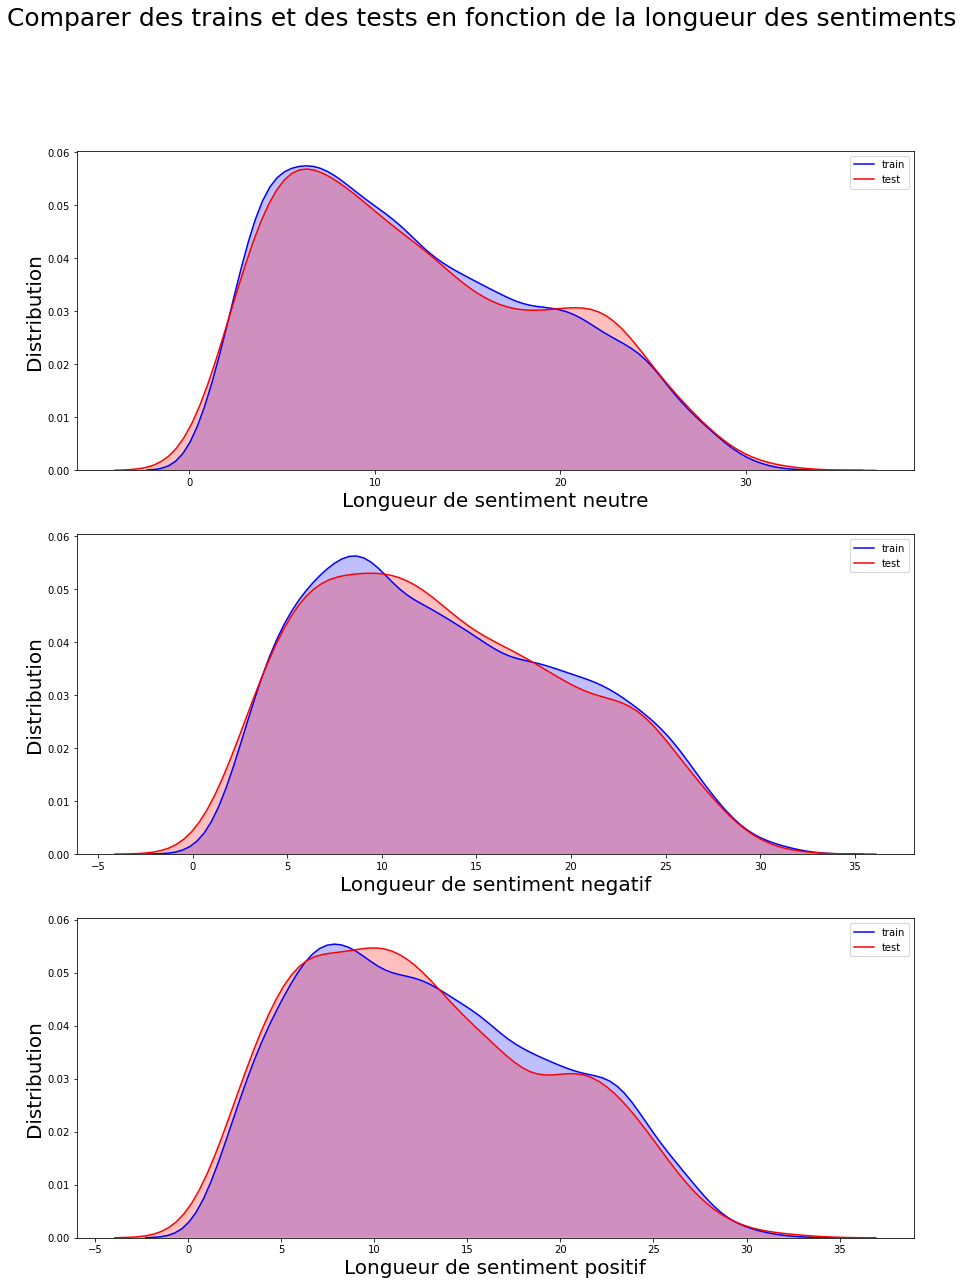

In [15]:
fig, axes = plt.subplots(3, 1, sharey = True, figsize = (15, 20))
fig.suptitle("Comparer des trains et des tests en fonction de la longueur des sentiments", fontsize = 25)
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "red", label = "test")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "red", label = "test")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "red", label = "test")
axes[0].set_xlabel("Longueur de sentiment neutre", fontsize = 20)
axes[0].set_ylabel("Distribution", fontsize = 20)
axes[1].set_xlabel("Longueur de sentiment negatif", fontsize = 20)
axes[1].set_ylabel("Distribution", fontsize = 20)
axes[2].set_xlabel("Longueur de sentiment positif", fontsize = 20)
axes[2].set_ylabel("Distribution", fontsize = 20)
plt.legend()

#### Nous pouvons voir sur les graphiques de distribution ci-dessus que la distribution de la longueur des mots est assez similaire dans les trains et les données de test pour chaque catégorie de sentiments

# Comparaison du test et de la colonne de texte sélectionnée

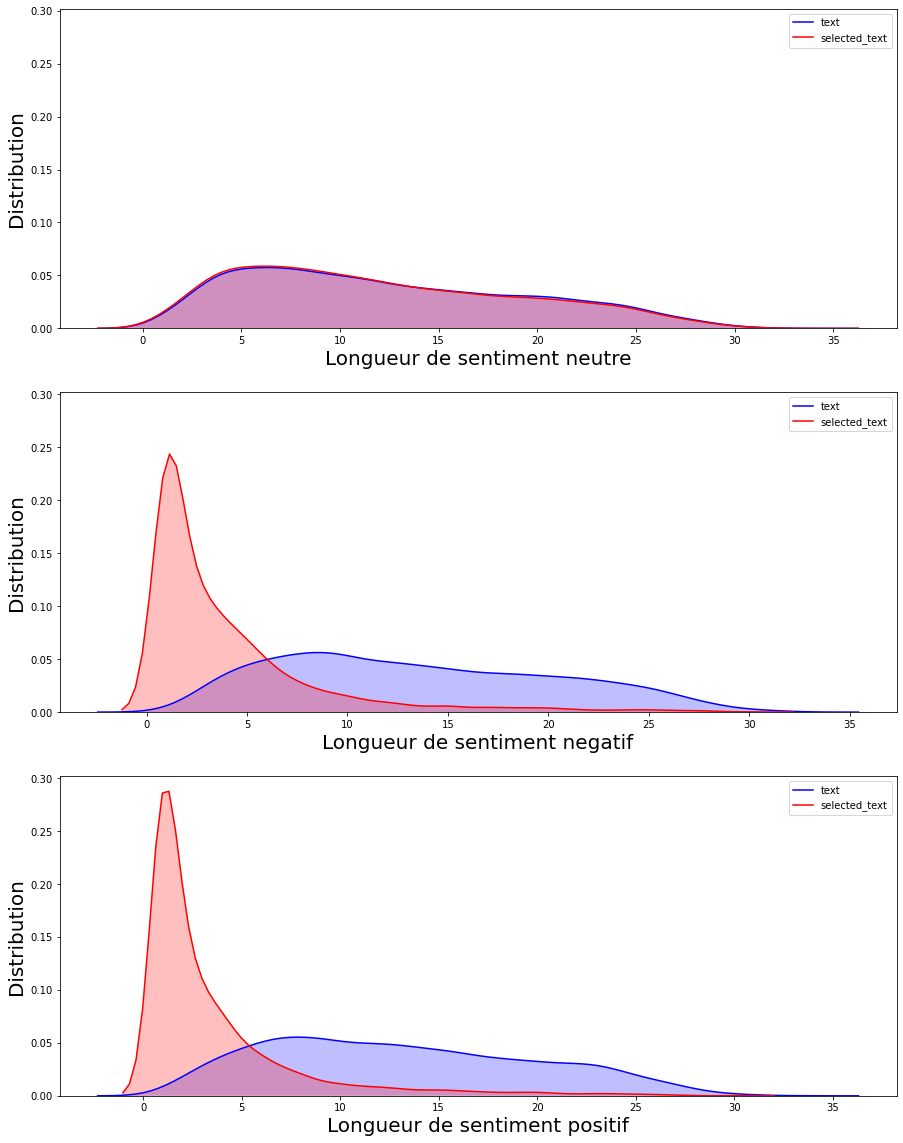

In [16]:
fig, axes = plt.subplots(3, 1, sharey = True, figsize = (15, 20))
fig.suptitle("", fontsize = 25)
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_selected_text"].values, ax  = axes[0], shade = True, color = "red", label = "selected_text")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_selected_text"].values, ax  = axes[1], shade = True, color = "red", label = "selected_text")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_selected_text"].values, ax  = axes[2], shade = True, color = "red", label = "selected_text")
axes[0].set_xlabel("Longueur de sentiment neutre", fontsize = 20)
axes[0].set_ylabel("Distribution", fontsize = 20)
axes[1].set_xlabel("Longueur de sentiment negatif", fontsize = 20)
axes[1].set_ylabel("Distribution", fontsize = 20)
axes[2].set_xlabel("Longueur de sentiment positif", fontsize = 20)
axes[2].set_ylabel("Distribution", fontsize = 20)
plt.legend()

#### Nous pouvons voir sur les graphiques ci-dessus que pour les phrases neutres, la distribution de la longueur est approximativement la même dans la colonne text et selected_text. Pour les sentiments négatifs et positifs, la longueur de la colonne selected_text est plus courte que celle de la colonne de texte

# statistiques sur les textes

### Le pourcentage de phrases de la colonne de texte est égal à la colonne selected_text pour un sentiment neutre

In [17]:
train["text"] = train["text"].apply(lambda x : x.strip())
train["selected_text"] = train["selected_text"].apply(lambda x : x.strip())


train["is_equal"] = (train["text"] == train["selected_text"])
df_neutral = train[train["sentiment"] == "neutral"]
percentage = (len(df_neutral[df_neutral["is_equal"] == True])/len(df_neutral)) * 100
print(f"Le pourcentage de phrases de la colonne de texte est égal à la colonne selected_text pour un sentiment neutre --> {percentage}")

Le pourcentage de phrases de la colonne de texte est égal à la colonne selected_text pour un sentiment neutre --> 89.9883061977152


#### Comme la plupart des données du train ["text"] sont les mêmes que celles du train ["selected_text"] pour un sentiment neutre. Je vais donc simplement copier-coller le test ["text"] pour la prédiction du sentiment neutre

# Compte de la ponctuation

In [18]:
def punc_count(data):
    return len([w for w in data if w in string.punctuation])

train["text_punc_count"] = train["text"].apply(lambda x : punc_count(x))
train["selected_text_punc_count"] = train["selected_text"].apply(lambda x : punc_count(x))

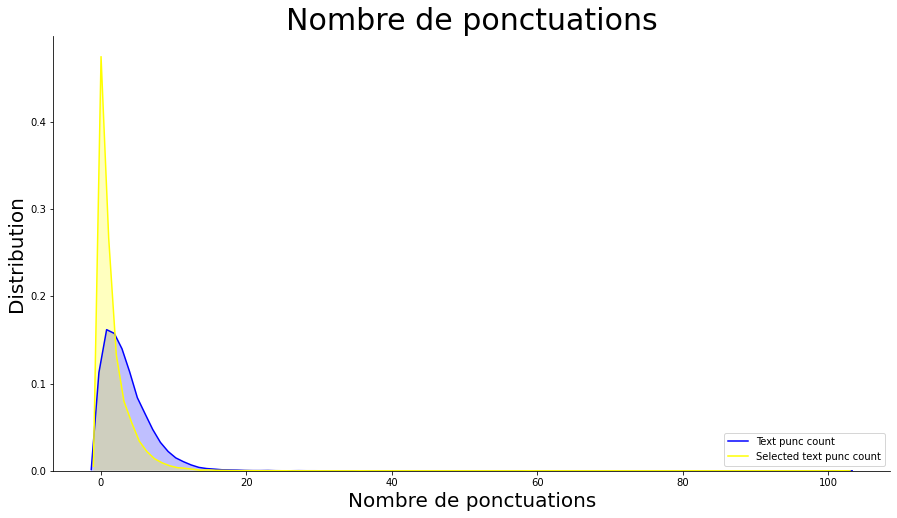

In [19]:
plt.figure(figsize = (15, 8))
sns.kdeplot(train["text_punc_count"].values, shade = True, color = "blue", label = "Text punc count")
sns.kdeplot(train["selected_text_punc_count"].values, shade = True, color = "yellow", label = "Selected text punc count")
plt.title("Nombre de ponctuations", fontsize = 30)
plt.xlabel("Nombre de ponctuations", fontsize = 20)
plt.ylabel("Distribution", fontsize = 20)
sns.despine()
plt.legend(loc = "lower right")

# Nuage de mots

In [20]:
# Mots les plus répétés dans la colonne de texte et selected_text
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "black",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (15, 15))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)

    plt.imshow(wordcloud)
    plt.show()

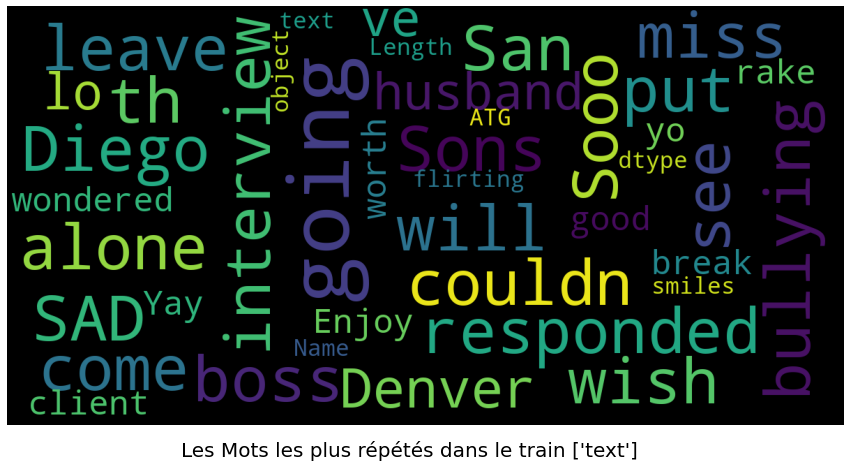

In [22]:
word_cloud(train["text"], "Les Mots les plus répétés dans le train ['text'] ")

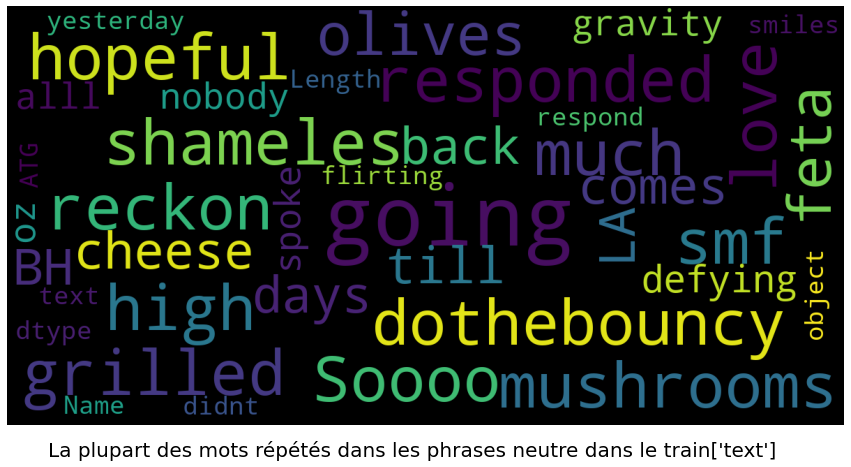

In [23]:
word_cloud(train[train["sentiment"] == "neutral"]["text"], "La plupart des mots répétés dans les phrases neutre dans le train['text']")

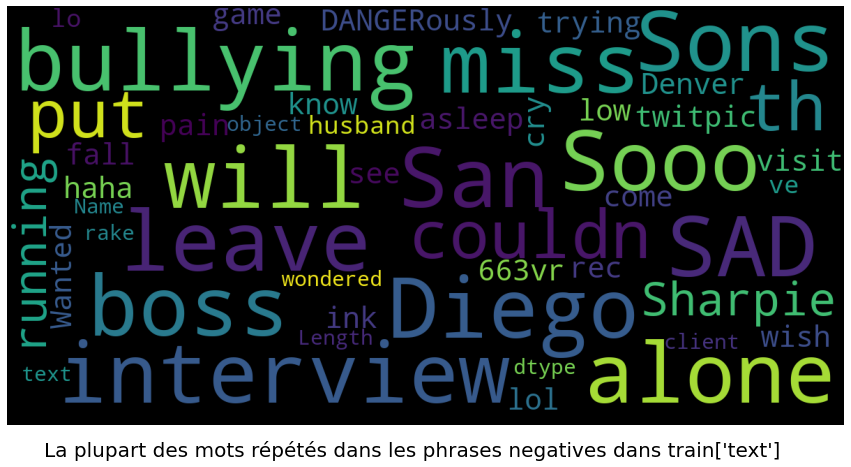

In [24]:
word_cloud(train[train["sentiment"] == "negative"]["text"], "La plupart des mots répétés dans les phrases negatives dans train['text']")

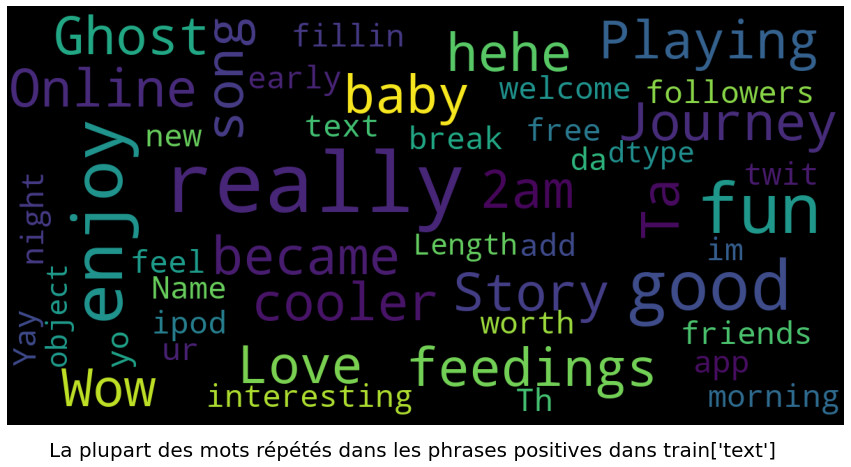

In [25]:
word_cloud(train[train["sentiment"] == "positive"]["text"], "La plupart des mots répétés dans les phrases positives dans train['text']")


# N-Grammes pour les phrases négatives neutres et positives

In [26]:
def n_grams(ngram, data):
    freq_dict = defaultdict(int)
    for text in data:
        tokens = [w for w in text.lower().split() if w != " " if w not in stopwords]
        ngrams = zip(*[tokens[i:] for i in range(ngram)])
        list_grams = [" ".join(ngram) for ngram in ngrams]
        for word in list_grams:
            freq_dict[word] += 1
    fd_sorted =  pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])   
    fd_sorted.columns = ["word", "wordcount"]
    return fd_sorted
                    
fd_sorted_neutral1 = n_grams(1, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative1 = n_grams(1, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive1 = n_grams(1, train[train["sentiment"] == "positive"]["text"]) 

fd_sorted_neutral2 = n_grams(2, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative2 = n_grams(2, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive2 = n_grams(2, train[train["sentiment"] == "positive"]["text"]) 

fd_sorted_neutral3 = n_grams(3, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative3 = n_grams(3, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive3 = n_grams(3, train[train["sentiment"] == "positive"]["text"]) 

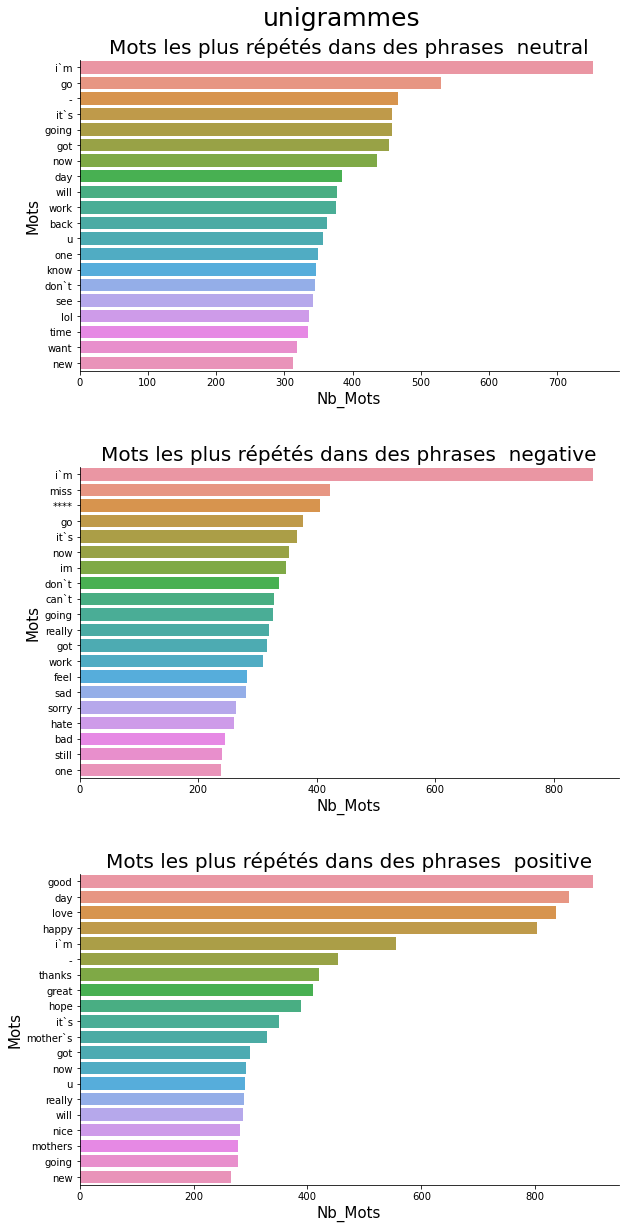

In [29]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("unigrammes", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(1)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Mots les plus répétés dans des phrases  {l[i]}", fontsize = 20)
    axes[i].set_xlabel("Nb_Mots", fontsize = 15)    
    axes[i].set_ylabel("Mots", fontsize = 15)

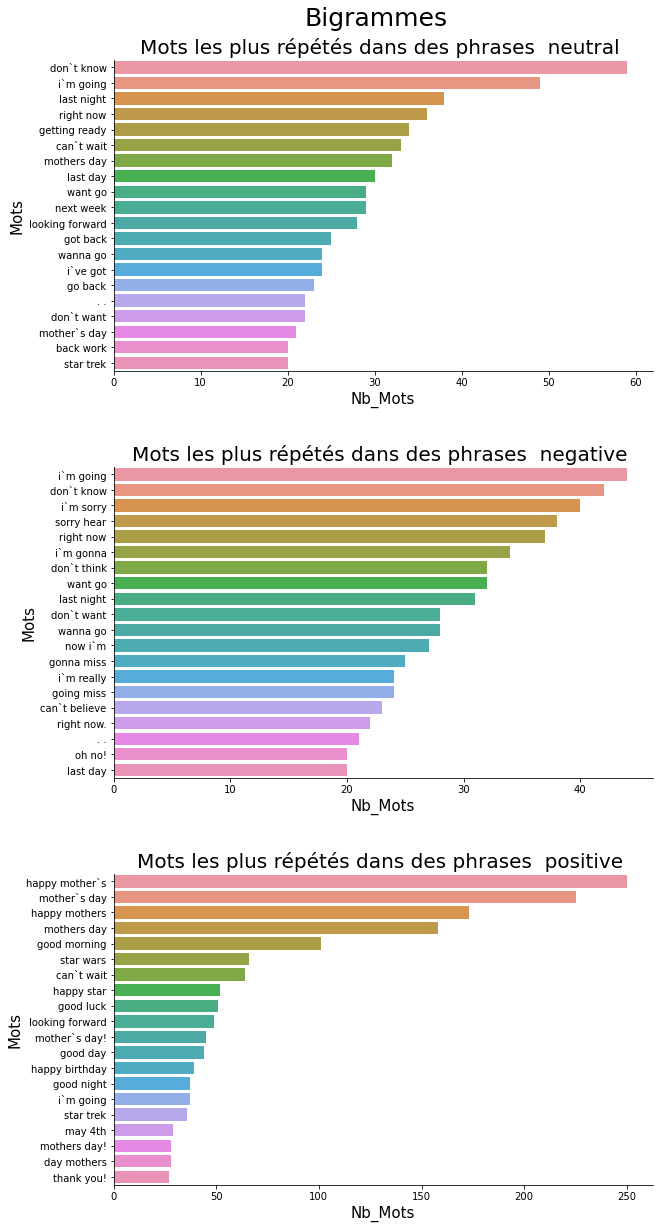

In [30]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("Bigrammes", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(2)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Mots les plus répétés dans des phrases  {l[i]} ", fontsize = 20)
    axes[i].set_xlabel("Nb_Mots", fontsize = 15)    
    axes[i].set_ylabel("Mots", fontsize = 15)

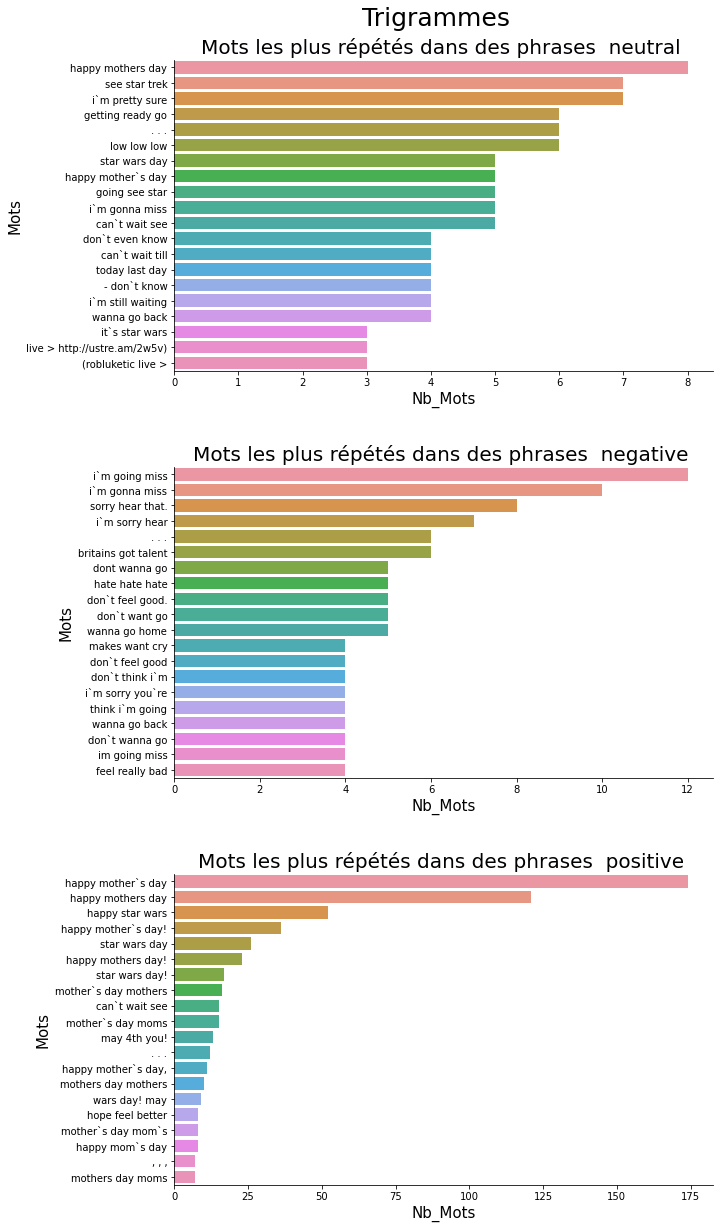

In [31]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("Trigrammes", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(3)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Mots les plus répétés dans des phrases  {l[i]} ", fontsize = 20)
    axes[i].set_xlabel("Nb_Mots", fontsize = 15)    
    axes[i].set_ylabel("Mots", fontsize = 15)